In [1]:
import os
WORKING_DIR = "/Users/thuang/Documents/Personal/code/microscopy-with-ml"
os.chdir(WORKING_DIR)
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/thuang/Documents/Personal/code/microscopy-with-ml


(520, 696, 2)


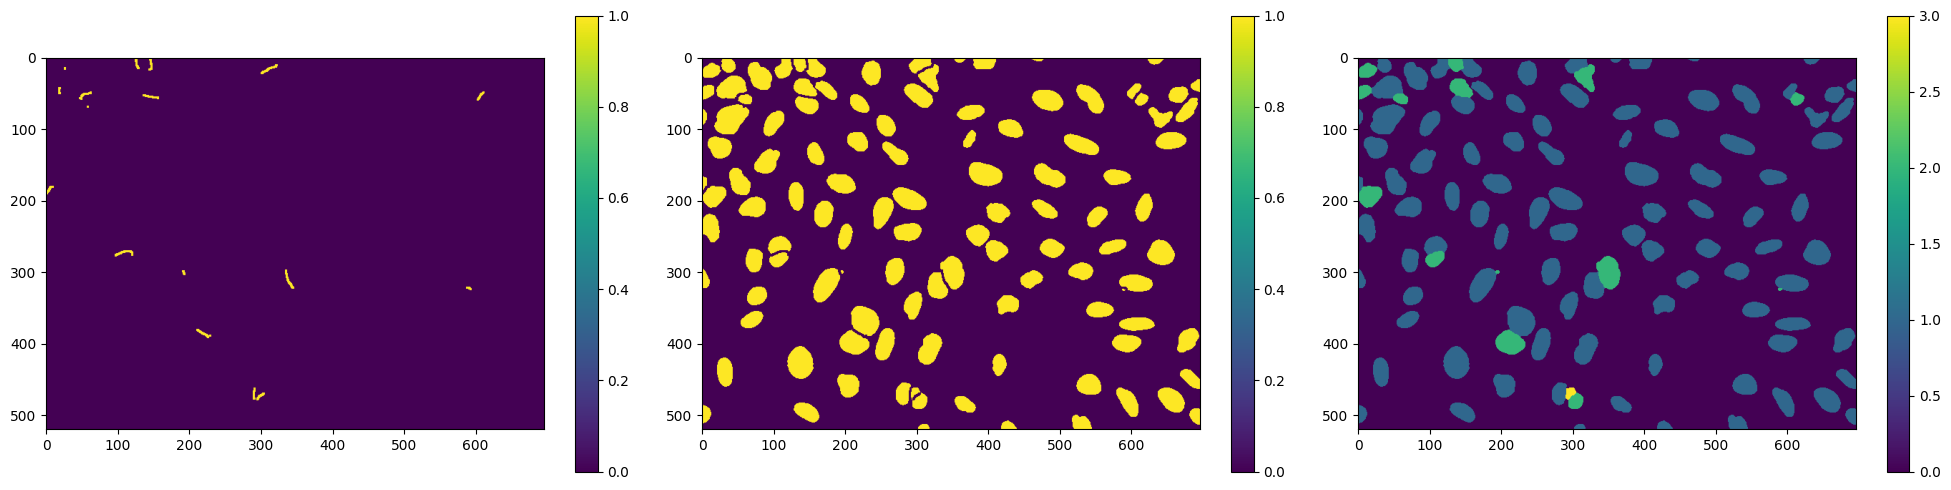

In [2]:
import cv2
import matplotlib.pyplot as plt
from mwm.components.image_processing import get_gt_mask_png

mask_path = "artifacts/data_ingestion/masks/IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.png"
mask_raw = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
mask_raw = cv2.cvtColor(mask_raw, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

mask = get_gt_mask_png(mask_raw[:,:,0])[:,:,1:] # leave out the 1st channel (empty), [0 1]

print(mask.shape)
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.colorbar(ax[0].imshow(mask[:,:,0]), ax=ax[0])
fig.colorbar(ax[1].imshow(mask[:,:,1]), ax=ax[1])
fig.colorbar(ax[2].imshow(mask_raw[:,:,0]), ax=ax[2])
plt.tight_layout()
plt.show()

111


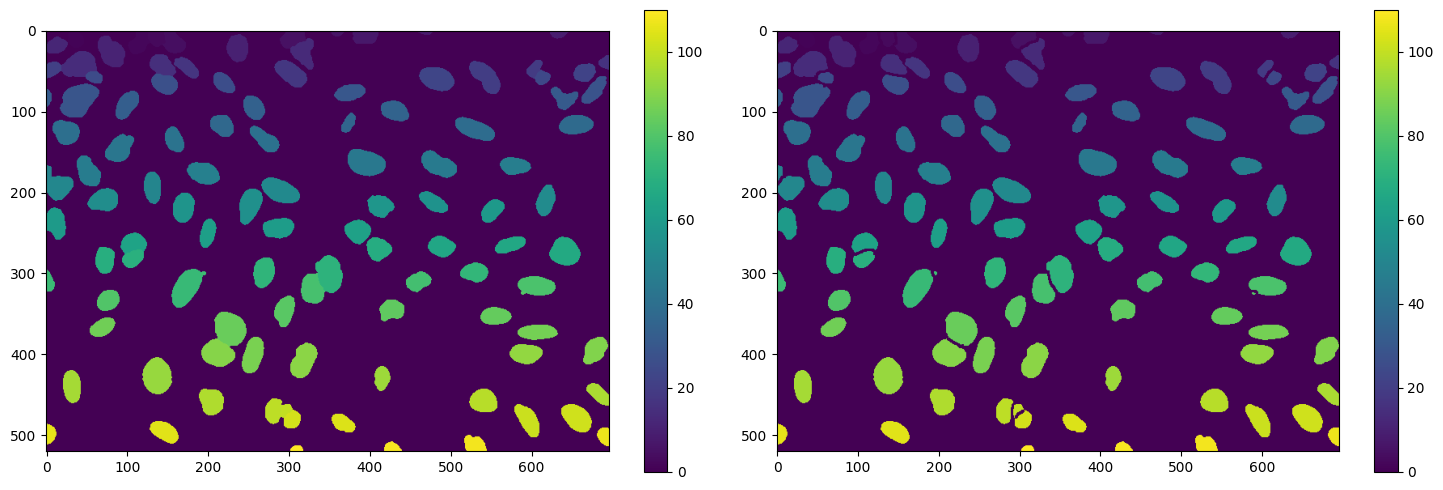

In [3]:
import numpy as np
from skimage import measure
from skimage.morphology import dilation, footprint_rectangle

labels_raw = measure.label(mask_raw[:,:,0], background=0)

labels_mask_gt = measure.label(mask[:,:,-1], background=0)
# labels_mask_gt = dilation(labels_mask_gt, footprint_rectangle((3, 3)))
print(len(np.unique(labels_mask_gt)))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.colorbar(ax[0].imshow(labels_raw), ax=ax[0])
fig.colorbar(ax[1].imshow(labels_mask_gt), ax=ax[1])
plt.tight_layout()
plt.show()

In [4]:
import numpy as np

def iou_object_labels(ground_truth, prediction):
    """
    Compute the pixel-level segmentation IoU for multiple objects in one image sample.
    Args:
        - ground_truth: 2D numpy array (int), ground truth mask, each object identified by pixels with the same unique value
        - prediction: 2D numpy array (int), predicted mask, each object identified by pixels with the same unique value
    Returns:
        - iou_matrix: 2D numpy array (float), IoU matrix for each object pair
    """
    
    # Count objects
    true_objects = len(np.unique(ground_truth))
    pred_objects = len(np.unique(prediction))
    
    # Compute intersection
    h = np.histogram2d(ground_truth.flatten(), prediction.flatten(), bins=(true_objects,pred_objects))
    intersection = h[0]
    
    # Area of objects
    area_true = np.histogram(ground_truth, bins=true_objects)[0]
    area_pred = np.histogram(prediction, bins=pred_objects)[0]
    
    # Calculate union
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    union = area_true + area_pred - intersection
    
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    
    # Compute Intersection over Union
    union[union == 0] = 1e-9
    iou_matrix = intersection/union
    
    return iou_matrix


def measures_at(threshold, iou_matrix):
    """
    Object level evaluation metrics at a given IoU threshold.
    Args:
        - threshold: float, IoU threshold
        - iou_matrix: 2D numpy array (float), IoU matrix for each object pair
    Returns:
        - f1: float, F1 score
        - precision: float, precision
        - recall: float, recall
        - jaccard: float, Jaccard index
        - TP: int, number of true positives objects identified in a image sample
        - FP: int, number of false positives objects identified in a image sample
        - FN: int, number of false negatives objects identified in a image sample
    """
    
    matches = iou_matrix > threshold
    
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    
    assert np.all(np.less_equal(true_positives, 1))
    assert np.all(np.less_equal(false_positives, 1))
    assert np.all(np.less_equal(false_negatives, 1))
    
    TP, FP, FN = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    
    f1 = 2*TP / (2*TP + FP + FN + 1e-9)
    precision = TP / (TP + FP + 1e-9)
    recall = TP / (TP + FN + 1e-9)
    jaccard = TP / (TP + FP + FN + 1e-9)
    
    return f1, precision, recall, jaccard, TP, FP, FN

In [ ]:
import pandas as pd
from skimage import measure
from skimage.morphology import dilation, footprint_rectangle
from mwm.components.image_processing import read_image_png
import mlflow


class EvaluationProcessor2Channel:
    def __init__(self):
        self.results = []
        self.thresholds = np.round(np.arange(0.5, 1.0, 0.05), 2)


    def prep_evaluation(self, prediction, mask_path):
        self.sample_name = os.path.basename(mask_path).split(".")[0]

        # Convert orginal mask to label
        mask_raw = read_image_png(mask_path)
        self.labels_gt = measure.label(mask_raw[:,:,0], background=0)

        # Convert prediction output to label
        prediction = prediction.permute(1, 2, 0).cpu().numpy()
        prediction = (prediction > 0.5).astype(np.uint8)
        mask_reconstructed = (prediction[:,:,1] - prediction[:,:,0]).squeeze()
        mask_reconstructed = mask_reconstructed[:mask_raw.shape[0], :mask_raw.shape[1]] # remove padding
        self.labels_pred = measure.label(mask_reconstructed, background=0)

        # dilate does not make gt mask score higher: 2 worse than 1
        # self.labels_pred = dilation(labels_pred_raw, footprint_rectangle((2, 2))) # dilate does not make gt mask score higher

    def update_metrics(self):
        iou_matrix = iou_object_labels(self.labels_gt, self.labels_pred)
        if iou_matrix.shape[0] > 0:
            mean_object_iou = np.max(iou_matrix, axis=0).mean()
        else:
            mean_object_iou = 0.0
        
        # Calculate F1 score at all thresholds
        for t in self.thresholds:
            f1, precision, recall, jaccard, tp, fp, fn = measures_at(t, iou_matrix)
            res = {
                "Sample": self.sample_name, 
                "Threshold": t, 
                "F1": f1, 
                "Precision": precision, 
                "Recall": recall, 
                "Jaccard": jaccard, 
                "MeanObjectIoU": mean_object_iou,
                "TP": tp, 
                "FP": fp, 
                "FN": fn
                }
            self.results.append(res)
    

    def log_key_metrics_to_mlflow(self):
        df = pd.DataFrame(self.results)
        df_agg = df.drop(columns=["Sample"]).groupby("Threshold").mean().reset_index().sort_values("Threshold", ascending=True)
        df_agg_list = df_agg.to_dict("records")
        for row_dict in df_agg_list:
            metrics = {k: v for k, v in row_dict.items() if k != "Threshold"}
            mlflow.log_metrics(metrics, step=int(row_dict["Threshold"]*100))
        mlflow.log_param("thresholds", self.thresholds)


    def save_results(self, output_path):
        df = pd.DataFrame(self.results)
        df.to_csv(output_path, index=False)

In [ ]:
from tqdm import tqdm
from datetime import datetime

from mwm.constants import *
from mwm.utils.common import read_yaml, load_json
from mwm.components.model_architecture import *
from mwm.components.dataset import *

class Evaluator():
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH
    ):
        self.config = read_yaml(config_filepath)
        self.params = load_json(params_filepath)

        # Make model
        self.model = make_model(self.params.network)

        # Make dataset
        self.image_dir = os.path.join(self.config.data_ingestion.unzip_dir, self.config.dataset.image_dir)
        self.mask_dir = os.path.join(self.config.data_ingestion.unzip_dir, self.config.dataset.mask_dir)
        with open(os.path.join(self.config.data_ingestion.unzip_dir, self.config.dataset.test_set_file), "r") as f:
            self.image_list_test = f.read().splitlines()
        self.test_dataset = make_dataset(self.params.dataset, self.image_dir, self.mask_dir, self.image_list_test)


    def load_model(self, model_path):
        self.model_path = model_path
        self.model.load_state_dict(torch.load(model_path))


    def handle_device(self):
        # Move model to GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)


    def evaluate(self):
        self.evaluate_processor = EvaluationProcessor2Channel()
        # Set model to evaluation mode
        self.model.eval()

        # Evaluate individual sample without batching
        batch_progress_bar = tqdm(self.test_dataset, desc=f"Evaluation", leave=True)
        with torch.no_grad():
            for image, mask in batch_progress_bar:
                mask_path = self.test_dataset.get_mask_path()

                # image = image.to(self.device)

                # # TODO: move to Dataset
                # # Pad images to match the target size
                # image = self.pad_images(image)

                # # TODO: any potnetial issue with not using data loader?
                # image = image.to(self.device).unsqueeze(0)  # Add batch dimension

                # output = self.model(image).squeeze()

                # self.evaluate_processor.prep_evaluation(output, mask_path)

                # test evaluation using GT mask
                self.evaluate_processor.prep_evaluation(mask, mask_path)
                self.evaluate_processor.update_metrics()

        mlflow.set_experiment("Evaluation")
        with mlflow.start_run():

            self.evaluate_processor.log_key_metrics_to_mlflow()

            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_path = os.path.join(
                self.config.evaluation.evaluation_dir,
                f"evaluation_{timestamp}_on_{os.path.basename(self.model_path).split('.')[0]}.csv"
            )
            self.evaluate_processor.save_results(save_path)

            mlflow.log_param("evaluation_save_path", save_path)

            # mlflow.log_param("model_path", self.model_path)
            # test gt mask
            mlflow.log_param("mask_path", "n/a. Evaluate GT mask vs GT labels.")
                

    # TODO: do this in Dataset: use crop and set image_size as a param
    @staticmethod
    def pad_images(images, target_height=544, target_width=704):
        """
        (Move to Dataset class and consider more flexible resizing options: crop, etc.)
        """
        import torch.nn.functional as F
        height, width = images.shape[-2], images.shape[-1]
        pad_height = target_height - height
        pad_width = target_width - width
        padding = (0, pad_width, 0, pad_height, 0, 0)  # (left, right, top, bottom)
        return F.pad(images, padding, mode='constant', value=0)

/Users/thuang/Documents/Personal/code/microscopy-with-ml/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
evaluator = Evaluator()
evaluator.load_model("artifacts/models/model_epoch1_20250224_112303.pth")
evaluator.handle_device()
evaluator.evaluate()

[2025-03-04 11:03:58,287: INFO: common: yaml file: config/config.yaml loaded successfully]
[2025-03-04 11:03:58,291: INFO: common: json file loaded succesfully from: params.json]
[2025-03-04 11:03:58,881: INFO: model_architecture: Model: unet_resnet34_2ch successfully created. ]
[2025-03-04 11:03:58,887: INFO: dataset: Dataset: seg_2ch successfully processed. ]


Evaluation: 100%|██████████| 50/50 [00:04<00:00, 12.16it/s]


#### Analyze GT mask vs GT labels: sanity check

In [13]:
df = pd.read_csv("artifacts/evaluation/evaluation_20250304_110106_on_model_epoch1_20250224_112303.csv")
print(len(df))
df.head()

500


,Sample,Threshold,F1,Precision,Recall,Jaccard,MeanObjectIoU,TP,FP,FN
0,IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC71...,0.50,0.890173,0.810526,0.987179,0.802083,0.809953,154,36,2
1,IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC71...,0.55,0.890173,0.810526,0.987179,0.802083,0.809953,154,36,2
2,IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC71...,0.60,0.890173,0.810526,0.987179,0.802083,0.809953,154,36,2
3,IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC71...,0.65,0.878613,0.800000,0.974359,0.783505,0.809953,152,38,4
4,IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC71...,0.70,0.878613,0.800000,0.974359,0.783505,0.809953,152,38,4


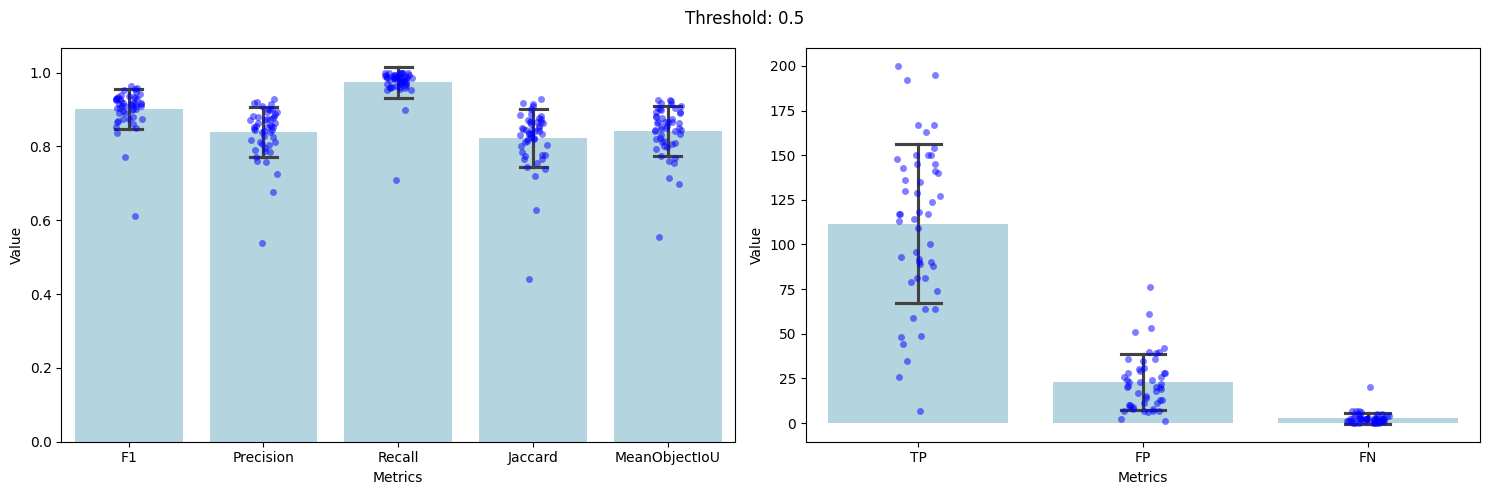

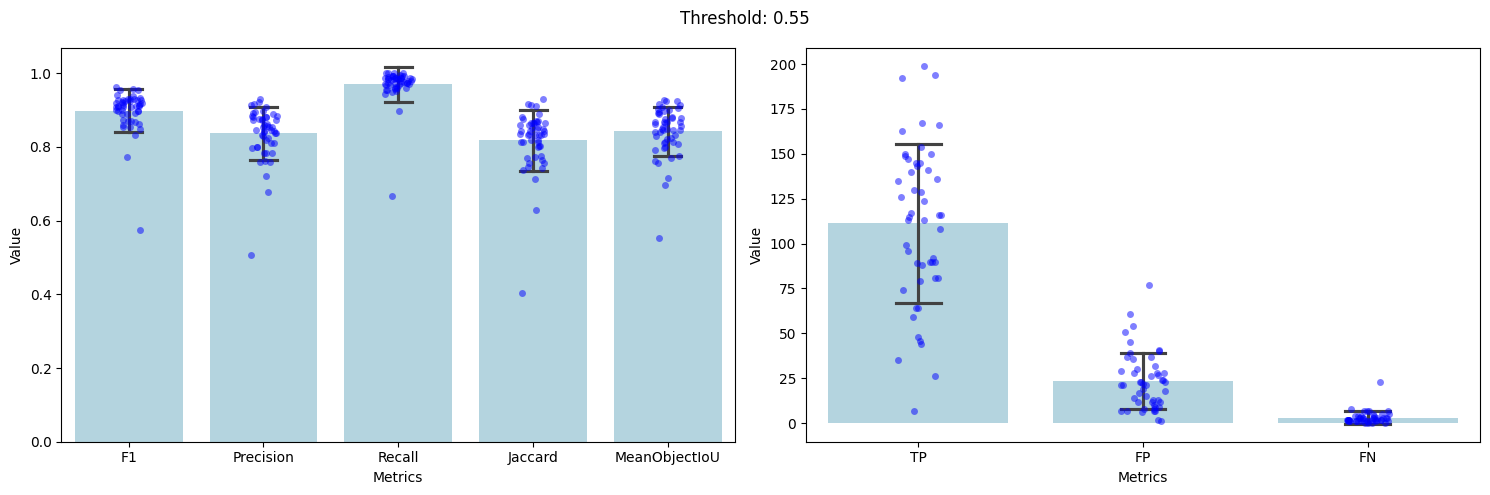

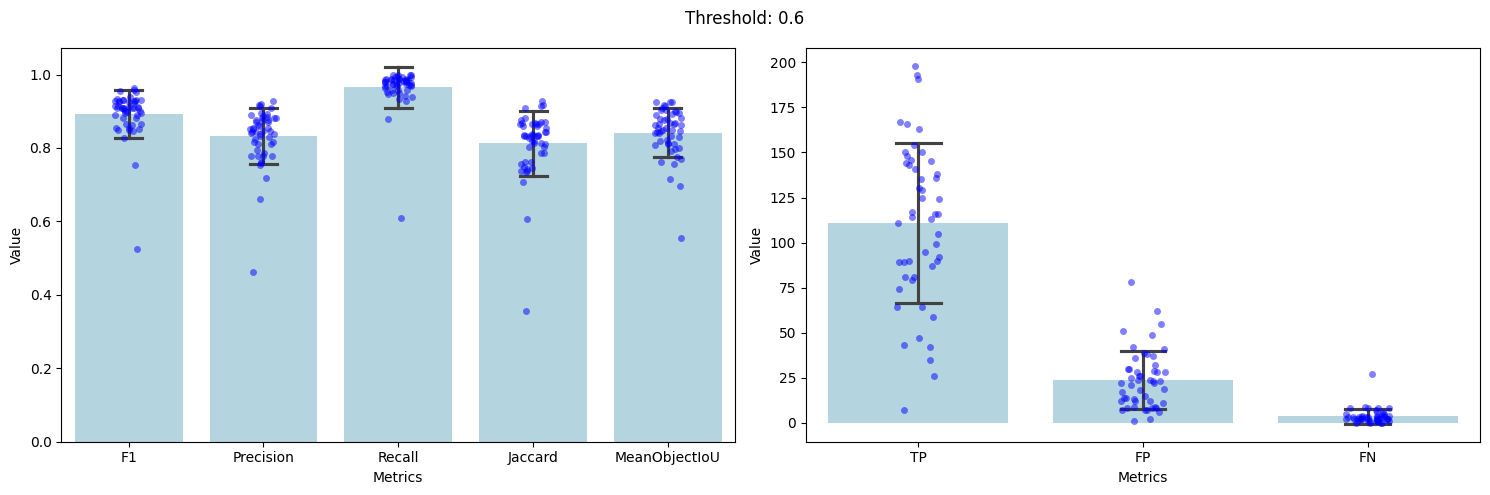

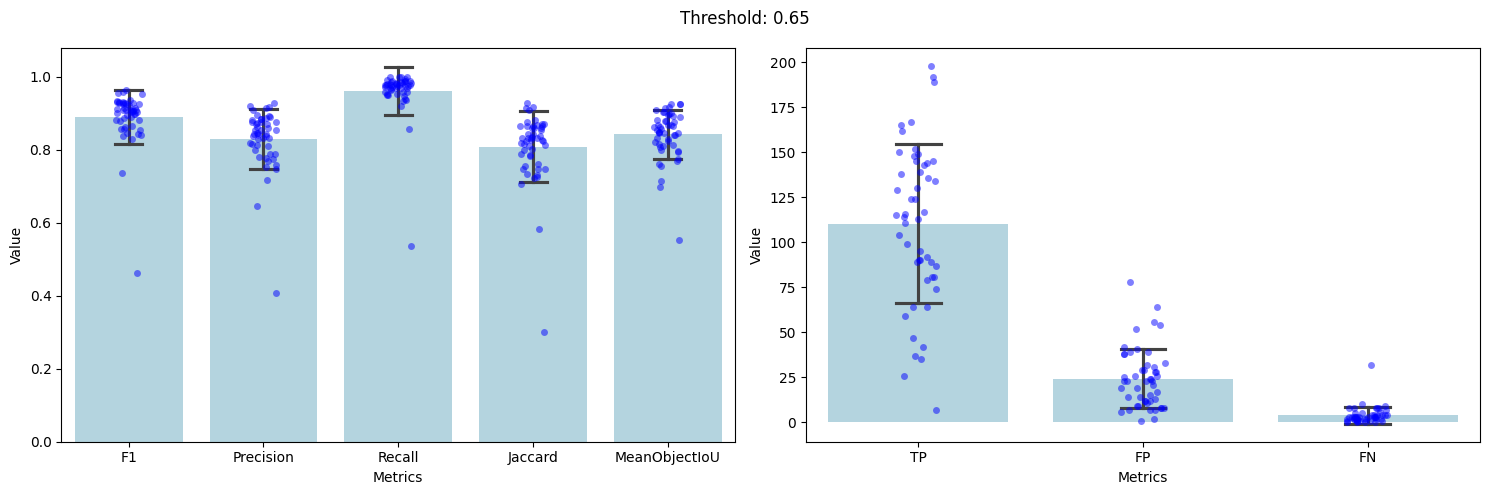

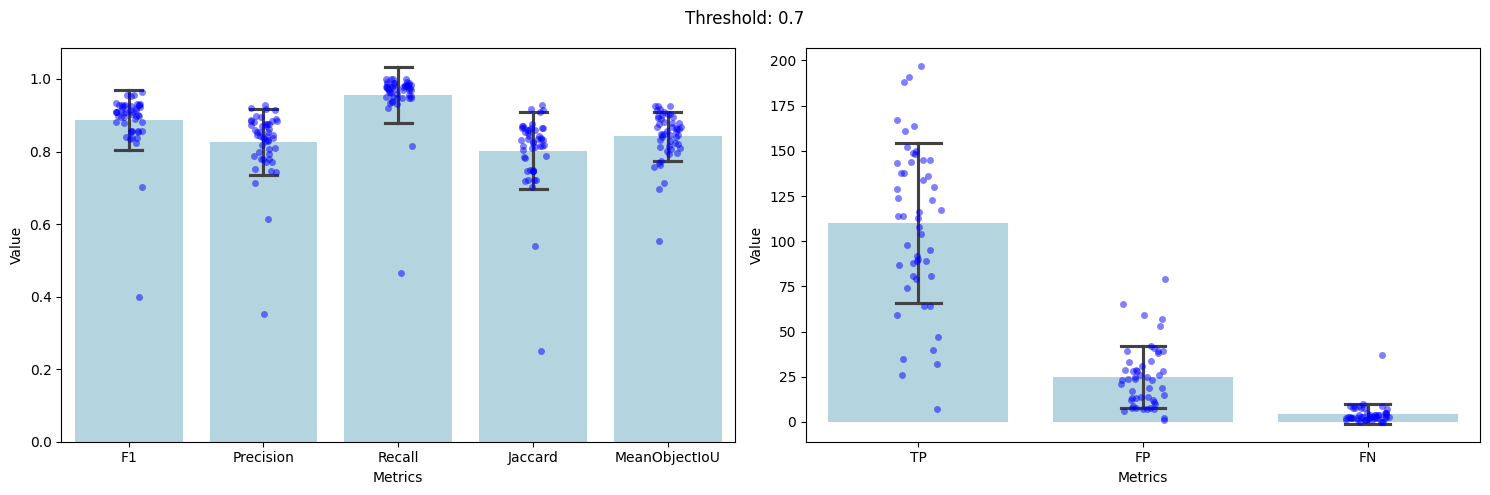

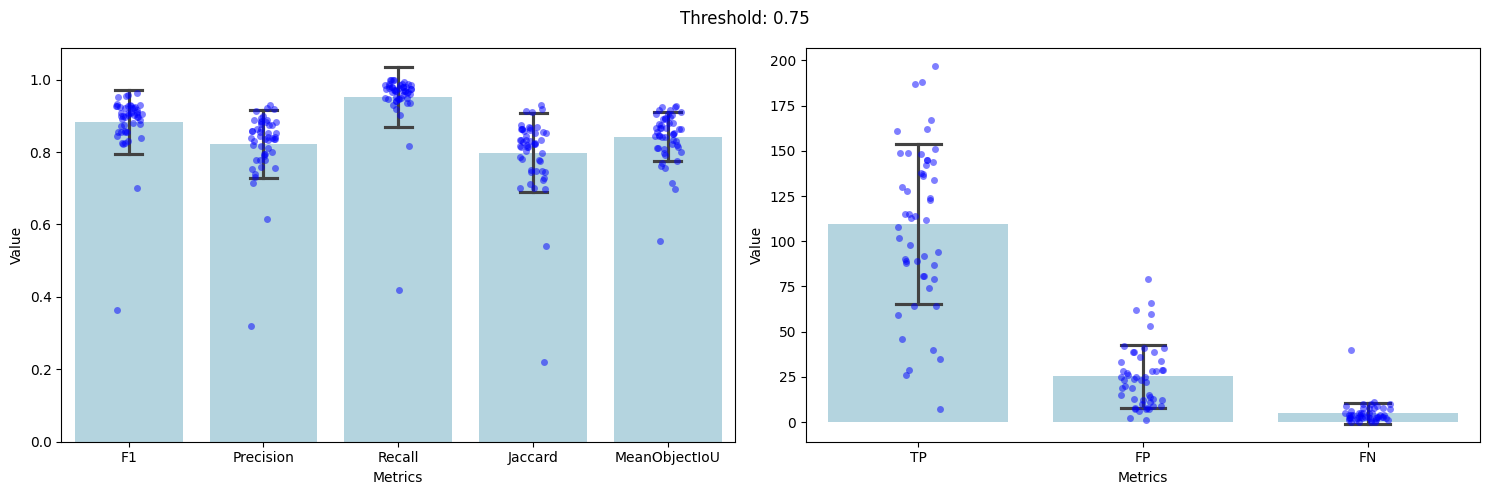

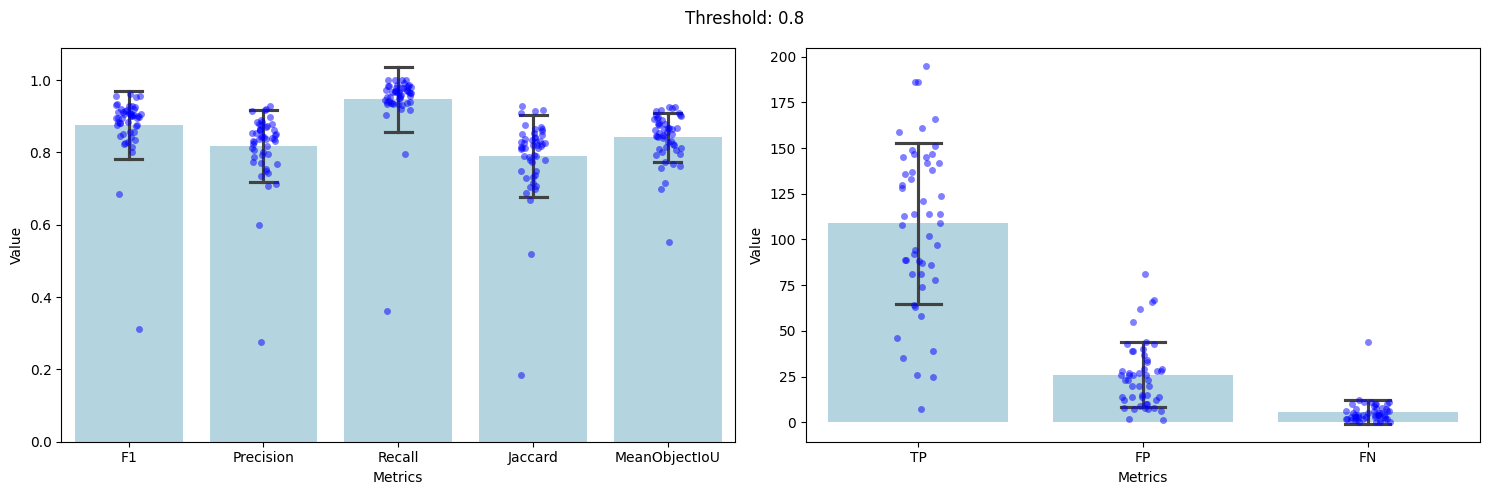

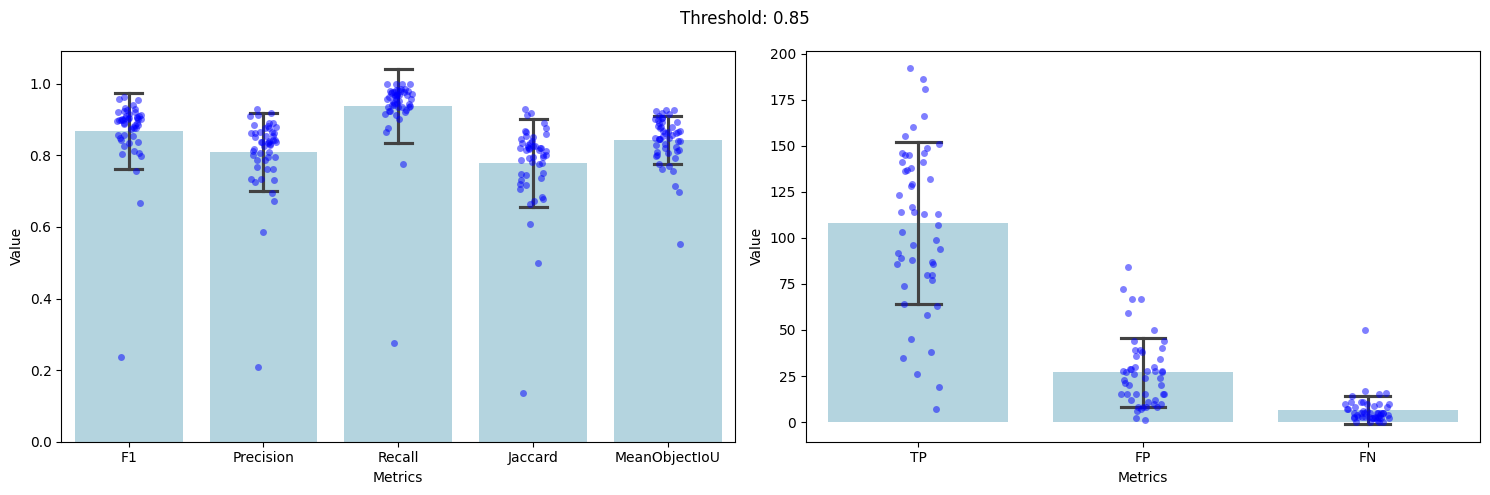

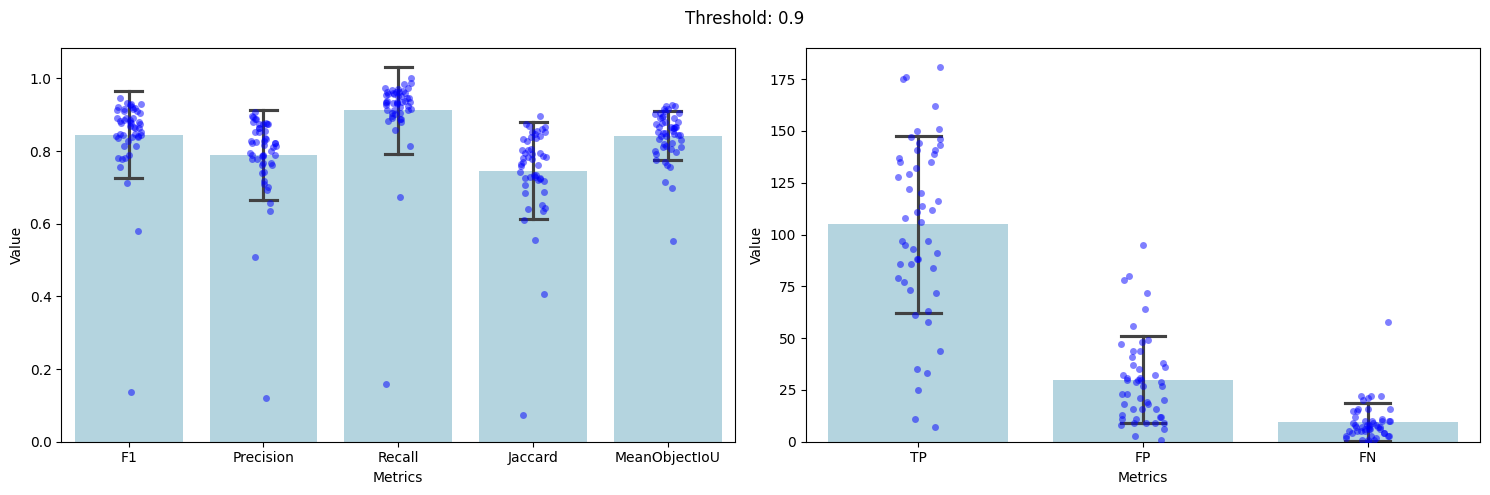

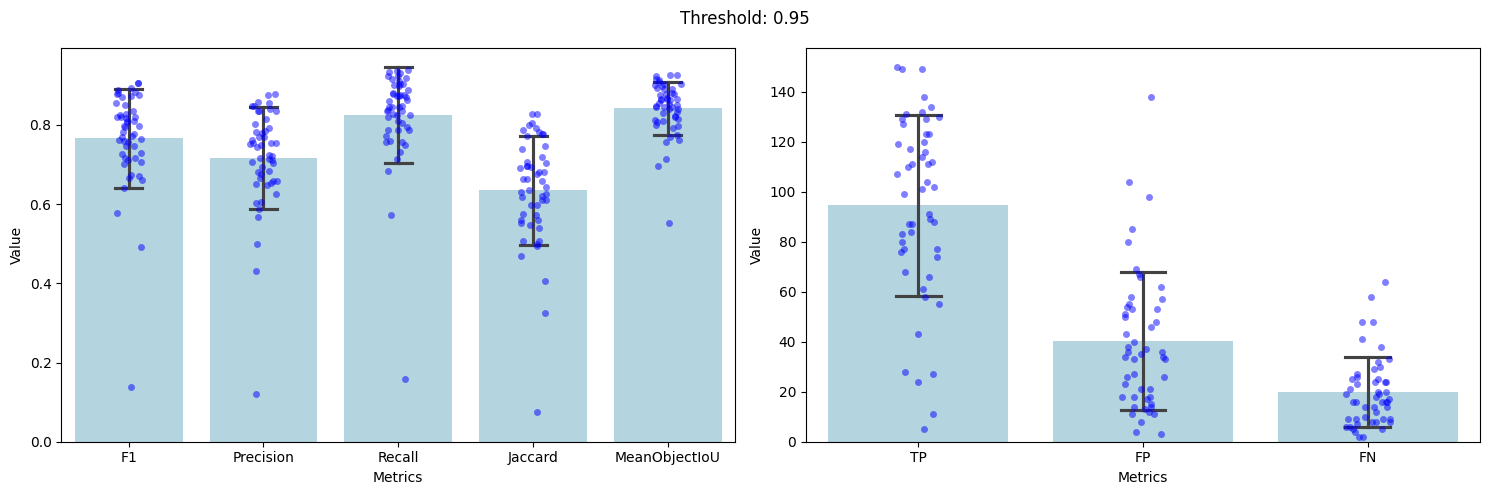

In [26]:
import seaborn as sns

for thresh in np.arange(0.5, 1.0, 0.05):
    threshold = np.round(thresh, 2)
    df_thresh = df[df["Threshold"] == threshold]
    df_long = df_thresh.drop(columns=["Sample", "Threshold"]).melt(var_name="Metrics", value_name="Value")

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.barplot(df_long[df_long["Metrics"].isin(["F1","Precision","Recall","Jaccard","MeanObjectIoU"])], x="Metrics", y="Value", estimator=np.mean, errorbar='sd', capsize=0.2, color='lightblue', ax=ax[0])
    sns.stripplot(df_long[df_long["Metrics"].isin(["F1","Precision","Recall","Jaccard","MeanObjectIoU"])], x="Metrics", y="Value", color='blue', jitter=True, alpha=0.5, ax=ax[0])
    sns.barplot(df_long[df_long["Metrics"].isin(["TP","FP","FN"])], x="Metrics", y="Value", estimator=np.mean, errorbar='sd', capsize=0.2, color='lightblue', ax=ax[1])
    sns.stripplot(df_long[df_long["Metrics"].isin(["TP","FP","FN"])], x="Metrics", y="Value", color='blue', jitter=True, alpha=0.5, ax=ax[1])
    plt.suptitle(f"Threshold: {threshold}")
    plt.tight_layout()
    plt.show()
